In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Penguin\anaconda3\envs\evasion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### C&W Attack
- L2 Attack

$$minmize \Vert \frac{1}{2}(tanh(w)+1)-x\Vert^2_2 + c\cdot f(\frac{1}{2}(tanh(w)+1))$$   
$$f(x')=max(max\{ Z(x')_i:i\neq t \} - Z(x')_t, -\kappa) $$      

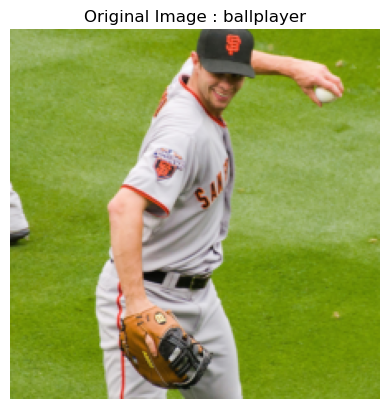

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)

output = model(image_tensor)

# print(output)

_, predict = torch.max(output, 1)

# print(predict)

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

plt.imshow(original_image)
plt.title(f"Original Image : {labels}")
plt.axis("off")
plt.show()

c&w attack:   0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\Penguin\AppData\Local\Temp\ipykernel_16168\3200597949.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
c&w attack: 100%|██████████| 3000/3000 [00:37<00:00, 80.12it/s]


racket


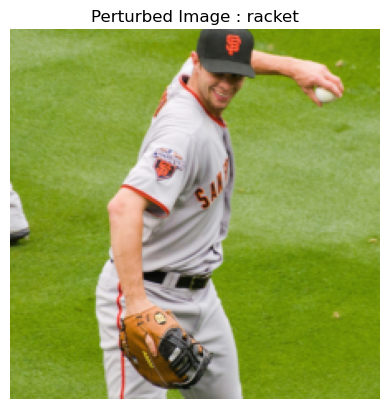

In [13]:
# C&W L2 Attack Function
def cw(model, images, labels, targeted=False, target_label=None, k=0, learning_rate=0.05, iters=1000, c=1e-4):
    images = images.to(device)
    labels = labels.to(device)
    
    if targeted and target_label is None:
        raise ValueError("For a targeted attack, target_label must be specified")

    def f(x):
        outputs = model(x)
        if targeted:
            one_hot_labels = torch.eye(len(outputs[0]))[target_label].to(device)
        else:
            one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())

        if targeted:
            return torch.clamp(i - j, min=-k)
        else:
            return torch.clamp(j - i, min=-k)

    w = torch.zeros_like(images, requires_grad=True).to(device)
    optimizer = optim.Adam([w], lr=learning_rate)

    for step in tqdm(range(iters), desc="c&w attack"):
        a = 0.5 * (nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c * f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    adversarial_images = 0.5 * (nn.Tanh()(w) + 1)
    return adversarial_images

c = 1e-1
k = 0
iters = 3000
learning_rate = 0.01
target_label = 20

adversarial_image = cw(model, image_tensor, predict, targeted=False, target_label=target_label, k=k, learning_rate=learning_rate, iters=iters, c=c)

adversarial_output = model(adversarial_image)

_, adversarial_predict = torch.max(adversarial_output, 1)

adversarial_labels = idx2label[adversarial_predict.item()]

print(adversarial_labels)

# Convert adversarial image to displayable format
adversarial_image_np = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
adversarial_image_np = np.clip(adversarial_image_np, 0, 1)

plt.imshow(adversarial_image_np)
plt.axis("off")
plt.title(f"Perturbed Image : {adversarial_labels}")
plt.show()